# Project5: Niraj 
## Modeling Accident time series - Recurrent Neural Network (RNN) model


In [532]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn import metrics 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow import keras
from tensorflow.keras.regularizers import l2


In [533]:
# Read the saved csv from the earlier notebook and set the index to the date_time column

df_accident_ts = pd.read_csv("./data/accident_ts_10years.csv", parse_dates= ['date_time'], index_col="date_time")

/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (3,6,8,11,20,24,26,28,30,32,34,36,38,40,42,44,48,50,52) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [534]:
df_accident_ts.reset_index()
df_accident_ts.sort_index(inplace=True)

In [535]:
df_accident_ts.index.isnull().sum()

0

In [538]:
# Create new df for modeling which has the columns we need, by day 
# Can do by day: 365*11 = 4000 records or by 3 hour windows = 32k records. Weekly and monthly will have too little data. 
# For now, only do daily.
df_model_day = df_accident_ts.resample("D").sum()[["fatals", "drunk_dr", "peds", "ve_total", "persons" ]]

In [537]:
df_model_day

,fatals,drunk_dr,peds,ve_total,persons
date_time,,,,,
2010-01-01,134,74,19,181,321
2010-01-02,61,25,9,74,117
2010-01-03,54,27,3,78,132
2010-01-04,70,13,9,104,136
2010-01-05,68,12,19,115,154
...,...,...,...,...,...
2020-12-27,98,27,21,128,201
2020-12-28,98,12,17,140,198
2020-12-29,88,16,22,126,194


### Let's Model! 

Recurrent Neural Networks are deep learning models used to solve problems with sequential input data. I will use the same five variables in the RNN model, as all the inputs are related to one another, to enable easier comparison between the two models. 

Similar to linear regression models, and unlike the time series, these variables are like the X variables used for predictions and the target variable is just the fatals. 

For RNN, we will use 4 variables - drunk_dr, peds, ve_total and persons to predict fatals.  

I will use a small test size of 2% during the train test split and the Keras TimeseriesGenerator to feed 16 sequences (batchsize) of length of 3 (and 5) through our model. Our validation data set is small (only 81 rows) so choose a small batch size of 16. The length is the number of lag observations to be used in the input portion of each sample.   

LSTM (long short-term memory) and GRU (Gated Recurrent Units) can alleviate the vanishing gradient problem which is a known shortcoming of RNNS especially with long time series extending over hundreds of periods. Along with Regularization using Dropout layers and EarlyStopping for optimization, we will attempt to get to a reasonably performing predictive model. 

### Train test Split

In [543]:
# Create X and y
# maybe add other highly correlated cols like construction zone 
X = df_model_day.drop(columns = ['fatals'])
y = df_model_day['fatals']


In [544]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle = False) # keep in chronological order 
# Difficult to predict far out in the future, keep only last 2% as our test
# The daily time periods spanning 11 years has a total of 4018 observations, of which the validation data of 2% is 81 observations. 


In [545]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3937, 4), (81, 4), (3937,), (81,))

In [546]:
# Scale training and testing data
sc =StandardScaler()
X_train_sc =sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

#### Keras TimeSeriesGenerator takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as length of the sequences/windows, spacing between two sequence/windows, etc., to produce batches of timeseries inputs and targets.


In [547]:
# Create training sequences

# 64 sequences of len=3 fed through our model at a time
train_seq = TimeseriesGenerator( X_train_sc, y_train, length = 3, batch_size=16) 


In [548]:
X_train

,drunk_dr,peds,ve_total,persons
date_time,,,,
2010-01-01,74,19,181,321
2010-01-02,25,9,74,117
2010-01-03,27,3,78,132
2010-01-04,13,9,104,136
2010-01-05,12,19,115,154
...,...,...,...,...
2020-10-07,22,26,167,218
2020-10-08,21,22,169,216
2020-10-09,34,31,229,303


In [549]:
# Create test sequences
# one bacth of data (batch of sequences)
train_seq[0][0]


array([[[ 3.78561972,  0.04294179,  1.51767441,  2.4346476 ],
        [-0.04499528, -1.50808429, -2.10584635, -1.62303778],
        [ 0.11135636, -2.43869993, -1.97038763, -1.32467856]],

       [[-0.04499528, -1.50808429, -2.10584635, -1.62303778],
        [ 0.11135636, -2.43869993, -1.97038763, -1.32467856],
        [-0.98310507, -1.50808429, -1.08990595, -1.2451161 ]],

       [[ 0.11135636, -2.43869993, -1.97038763, -1.32467856],
        [-0.98310507, -1.50808429, -1.08990595, -1.2451161 ],
        [-1.06128089,  0.04294179, -0.71739447, -0.88708504]],

       [[-0.98310507, -1.50808429, -1.08990595, -1.2451161 ],
        [-1.06128089,  0.04294179, -0.71739447, -0.88708504],
        [-1.53033579, -1.50808429, -2.03811699, -1.88161577]],

       [[-1.06128089,  0.04294179, -0.71739447, -0.88708504],
        [-1.53033579, -1.50808429, -2.03811699, -1.88161577],
        [-0.82675344, -0.57746864, -0.34488299, -0.13124168]],

       [[-1.53033579, -1.50808429, -2.03811699, -1.88161577]

In [550]:
# First batch of target values 
train_seq[0][1]

array([70, 68, 55, 84, 61, 84, 60, 68, 76, 70, 97, 75, 81, 85, 75, 77])

In [551]:
y_train

date_time
2010-01-01    134
2010-01-02     61
2010-01-03     54
2010-01-04     70
2010-01-05     68
             ... 
2020-10-07    114
2020-10-08    115
2020-10-09    147
2020-10-10    168
2020-10-11    126
Freq: D, Name: fatals, Length: 3937, dtype: int64

In [552]:
# how many batches in the whole training set

len(train_seq)

246

In [553]:
X_train.head() # 5 columns

,drunk_dr,peds,ve_total,persons
date_time,,,,
2010-01-01,74,19,181,321
2010-01-02,25,9,74,117
2010-01-03,27,3,78,132
2010-01-04,13,9,104,136
2010-01-05,12,19,115,154


In [554]:
X_test # small percentage

,drunk_dr,peds,ve_total,persons
date_time,,,,
2020-10-12,18,21,173,229
2020-10-13,19,21,155,194
2020-10-14,15,17,175,219
2020-10-15,18,25,161,201
2020-10-16,27,39,190,265
...,...,...,...,...
2020-12-27,27,21,128,201
2020-12-28,12,17,140,198
2020-12-29,16,22,126,194


In [555]:
# Now do for test data, same len and batch_size as train data
test_seq = TimeseriesGenerator( X_test_sc, y_test, length = 3, batch_size=16) 
len(test_seq)

5

## Modeling time!
---

Now it's time to design our RNN model. We'll have:

- 2 [`GRU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) layers
- 1 `Dense` output layer

We're doing a linear regression problem

In [469]:
## Check shape of a single sequence of data (this will be the input shape for our model)

train_seq[0][0][0].shape

(3, 4)

In [556]:
# Design RNN
model = Sequential()

## First GRU layer returns hidden state, passes back into self
model.add(GRU(16, input_shape = train_seq[0][0][0].shape, 
             return_sequences=True))
## Second GRU layer passes outputs forward to next layer
model.add(GRU(8, return_sequences=False))

model.add(Dense(8, activation = 'relu'))

model.add(Dense(1)) # output layer

model.compile(
    optimizer="adam", ## Adam is the most commonly used optimized
    loss="mean_squared_error", # or 'mse' is the most common loss function for regression
    metrics= [tf.keras.metrics.RootMeanSquaredError(),'mae', 'mape'], # Additional metrics to track - no 'rmse' so instead we can use tensorflow's RMSE function
)

In [557]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_25 (GRU)                (None, 3, 16)             1056      
                                                                 
 gru_26 (GRU)                (None, 8)                 624       
                                                                 
 dense_55 (Dense)            (None, 8)                 72        
                                                                 
 dense_56 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________


In [558]:
# Fit to training sequences, validate with test sequences

history = model.fit(train_seq, epochs = 50, verbose = 1, validation_data=test_seq)

Epoch 1/50
246/246 [==============================] - 139s 18ms/step - loss: 8591.0410 - root_mean_squared_error: 92.6879 - mae: 89.9934 - mape: 93.9188 - val_loss: 9403.1074 - val_root_mean_squared_error: 96.9696 - val_mae: 95.2892 - val_mape: 85.7103
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 4811.1318 - root_mean_squared_error: 69.3623 - mae: 65.5703 - mape: 67.1993 - val_loss: 4621.2686 - val_root_mean_squared_error: 67.9799 - val_mae: 65.5599 - val_mape: 58.1516
Epoch 3/50
246/246 [==============================] - 2s 6ms/step - loss: 1844.7451 - root_mean_squared_error: 42.9505 - mae: 36.6921 - mape: 35.4949 - val_loss: 1829.6494 - val_root_mean_squared_error: 42.7744 - val_mae: 38.8134 - val_mape: 33.3583
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 696.4070 - root_mean_squared_error: 26.3895 - mae: 20.3541 - mape: 19.7729 - val_loss: 836.5917 - val_root_mean_squared_error: 28.9239 - val_mae: 23.6438 - val_mape: 19.6588

y_test_baseline: 95.47320294640589, y_train_baseline_mean: 95.47320294640589, baseline_RMSE: 23.24519113999734, baseline MAPE: 0.148302794152187, baseline MAE: 0.148302794152187 


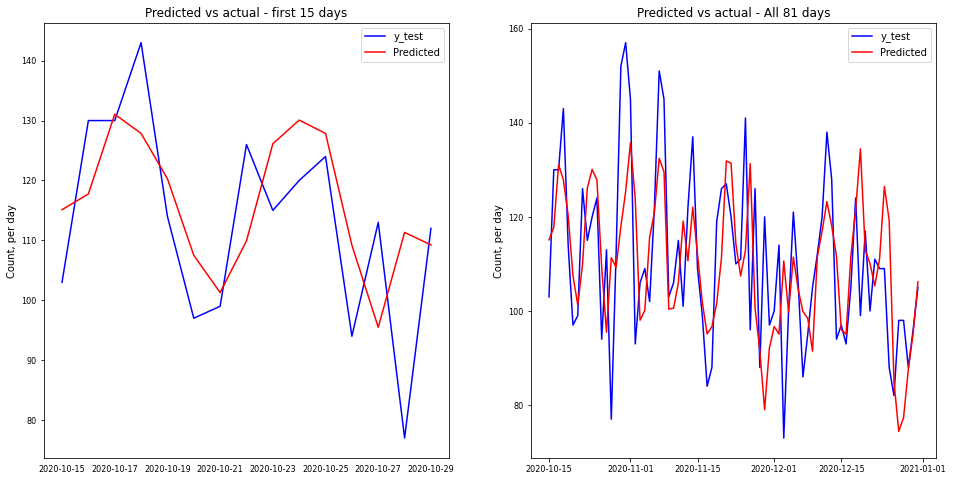

In [561]:
# Evaluate the model performance with various metrics

y_train_preds = model.predict(train_seq)
y_test_preds = model.predict(test_seq)

# baseline
y_test_baseline = [y_train.mean()]*len(y_test)

baseline_RMSE = mean_squared_error(y_test, y_test_baseline)**0.5
baseline_mean = y_train.mean()
y_train_baseline = [y_train.mean()]*len(y_train)

baseline_MAPE = mean_absolute_percentage_error(y_test, y_test_baseline)
baseline_MAE = mean_absolute_error (y_test, y_test_baseline)

print( f"y_test_baseline: {y_test_baseline[0]}, y_train_baseline_mean: {baseline_mean}, baseline_RMSE: {baseline_RMSE}, baseline MAPE: {baseline_MAPE}, baseline MAE: {baseline_MAPE} ")

#print( f"Baseline R2 score: {metrics.r2_score(y_train, y_train_baseline)}" )
#print( f"Baseline Training R2 score: {metrics.r2_score(y_test, y_test_baseline)}" )

#print( f"Training R2 score: {metrics.r2_score( y_train[3:], y_train_preds)}") # R2 scores are not relevant in RNN, but print anyway
#print( f"Test R2 score: {metrics.r2_score( y_test[3:], y_test_preds[:])}") 

y_test_preds_df = pd.DataFrame(data = y_test_preds, index = y_test[3:].index, columns = ["y_test_preds"])

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))
labels = ['y_test', 'preds']

ax1.plot( y_test[3:18], color = 'blue', label="y_test")
ax1.plot( y_test_preds_df[:15], color = 'red', label="Predicted")
ax1.set_title("Predicted vs actual - first 15 days")
ax1.xaxis.set_ticks_position('none')
ax1.set_ylabel("Count, per day")
ax1.tick_params(labelsize=8)
ax1.legend()

ax2.plot( y_test[3:], color = 'blue', label="y_test")
ax2.plot( y_test_preds_df[:], color = 'red', label="Predicted")
ax2.set_title("Predicted vs actual - All 81 days")
ax2.set_ylabel("Count, per day")
ax2.tick_params(labelsize=8)
ax2.legend();


#### **Interpretation:**  
The predictions are quite good, more so in the first 15 days. Over the total 81 days of predictions, the predictions don't quite match the peaks. In fact, towards the end they overshoot the data considerably. 


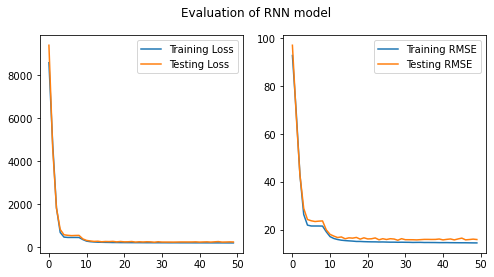

In [562]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))

## Plot Training & Validation Loss
ax1.plot(history.history['loss'], label="Training Loss")
ax1.plot(history.history['val_loss'], label="Testing Loss")
ax1.legend();

## Plot Training & Validation Accuracy
ax2.plot(history.history['root_mean_squared_error'], label="Training RMSE")
ax2.plot(history.history['val_root_mean_squared_error'], label="Testing RMSE")
ax2.legend();

plt.suptitle("Evaluation of RNN model");

#### **Interpretation:**  
The graphs are almost perfect! The testing RMSE is marginally higher than the Training RMSE, showing the model is not overfit and should do a good job on predicting new unseen data. 

#### Now try additional layers

LSTM in this model, rest everything is the same

In [563]:
# change GRU to LSTM

model_2 = Sequential()

## First LSTM layer returns hidden state, passes back into self
model_2.add(LSTM(16, input_shape = train_seq[0][0][0].shape, 
             return_sequences=True))
## Second LSTM layer passes outputs forward to next layer
model_2.add(LSTM(8, return_sequences=False))

model_2.add(Dense(8, activation = 'relu'))

model_2.add(Dense(1))

model_2.compile(
    optimizer="adam",
    loss="mean_squared_error", 
    metrics= [tf.keras.metrics.RootMeanSquaredError(),'mae']
)


In [564]:
model_2.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 3, 16)             1344      
                                                                 
 lstm_31 (LSTM)              (None, 8)                 800       
                                                                 
 dense_57 (Dense)            (None, 8)                 72        
                                                                 
 dense_58 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,225
Trainable params: 2,225
Non-trainable params: 0
_________________________________________________________________


In [565]:
history_2 = model_2.fit( train_seq, epochs = 50, verbose = 1, validation_data = test_seq)

Epoch 1/50
246/246 [==============================] - 13s 12ms/step - loss: 8518.6543 - root_mean_squared_error: 92.2966 - mae: 89.5589 - val_loss: 9133.0586 - val_root_mean_squared_error: 95.5670 - val_mae: 93.8584
Epoch 2/50
246/246 [==============================] - 1s 4ms/step - loss: 5003.0576 - root_mean_squared_error: 70.7323 - mae: 66.9619 - val_loss: 5200.6714 - val_root_mean_squared_error: 72.1157 - val_mae: 69.8373
Epoch 3/50
246/246 [==============================] - 1s 4ms/step - loss: 2291.4111 - root_mean_squared_error: 47.8687 - mae: 42.1725 - val_loss: 2379.0151 - val_root_mean_squared_error: 48.7752 - val_mae: 45.3406
Epoch 4/50
246/246 [==============================] - 1s 4ms/step - loss: 909.1210 - root_mean_squared_error: 30.1516 - mae: 23.7005 - val_loss: 1081.1810 - val_root_mean_squared_error: 32.8813 - val_mae: 27.9831
Epoch 5/50
246/246 [==============================] - 1s 4ms/step - loss: 523.3707 - root_mean_squared_error: 22.8773 - mae: 17.7883 - val_loss

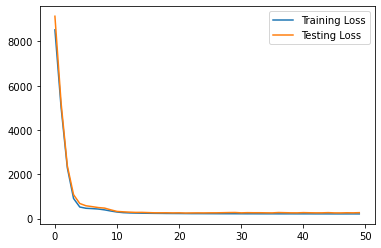

In [566]:
## Plot Training & Validation Loss
plt.plot(history_2.history['loss'], label="Training Loss")
plt.plot(history_2.history['val_loss'], label="Testing Loss")
plt.legend();

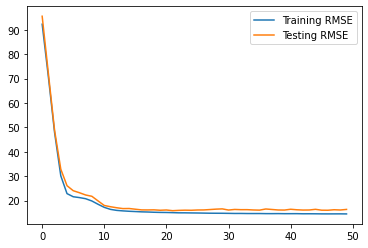

In [567]:
## Plot Training & Validation Accuracy
plt.plot(history_2.history['root_mean_squared_error'], label="Training RMSE")
plt.plot(history_2.history['val_root_mean_squared_error'], label="Testing RMSE")
plt.legend();


y_test_baseline: 95.47320294640589, y_train_baseline_mean: 95.47320294640589, baseline_RMSE: 23.24519113999734 


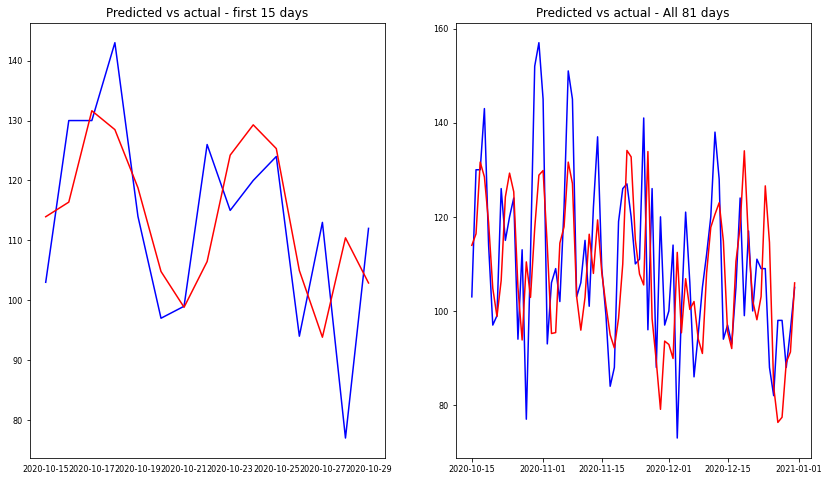

In [569]:
y_train_preds = model_2.predict(train_seq)
y_test_preds = model_2.predict(test_seq)

# baseline
y_test_baseline = [y_train.mean()]*len(y_test)

baseline_RMSE = mean_squared_error(y_test, y_test_baseline)**0.5
baseline_mean = y_train.mean()
y_train_baseline = [y_train.mean()]*len(y_train)

print( f"y_test_baseline: {y_test_baseline[0]}, y_train_baseline_mean: {baseline_mean}, baseline_RMSE: {baseline_RMSE} ")


#print( metrics.r2_score(y_train, y_train_baseline) )
#print( metrics.r2_score(y_test, y_test_baseline) )

#print( f"Training R2 score: {metrics.r2_score( y_train[3:], y_train_preds)}")
#print( f"Test R2 score: {metrics.r2_score( y_test[-15:], y_test_preds[-15:])}") # last few days 

y_test_preds_df = pd.DataFrame(data = y_test_preds, index = y_test[3:].index, columns = ["y_test_preds"])

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,8))

ax1.plot( y_test[3:18], color = 'blue')
ax1.plot( y_test_preds_df[:15], color = 'red')
ax1.set_title("Predicted vs actual - first 15 days")
ax1.xaxis.set_ticks_position('none')
ax1.tick_params(labelsize=8)

ax2.plot( y_test[3:], color = 'blue')
ax2.plot( y_test_preds_df[:], color = 'red')
ax2.set_title("Predicted vs actual - All 81 days")
ax2.tick_params(labelsize=8)


#### Next variation 

In [570]:
# 3 - RNN with LSTM and Regularization

model_3 = Sequential()

## First LSTM layer returns hidden state, passes back into self
model_3.add(LSTM(16, input_shape = train_seq[0][0][0].shape, 
             return_sequences=True))
## Second LSTM layer passes outputs forward to next layer
model_3.add(LSTM(8, return_sequences=False))

model_3.add(Dense(8, activation = 'relu', kernel_regularizer=l2(0.001)))
model_3.add(Dropout(0.2))

model_3.add(Dense(1))

model_3.compile(
    optimizer="adam",
    loss="mean_squared_error", 
    metrics= [tf.keras.metrics.RootMeanSquaredError(),'mae']
)



In [571]:
model_3.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 3, 16)             1344      
                                                                 
 lstm_33 (LSTM)              (None, 8)                 800       
                                                                 
 dense_59 (Dense)            (None, 8)                 72        
                                                                 
 dropout_14 (Dropout)        (None, 8)                 0         
                                                                 
 dense_60 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,225
Trainable params: 2,225
Non-trainable params: 0
_________________________________________________________________


In [572]:
history_3 = model_3.fit(train_seq, epochs = 40, verbose = 1, validation_data = test_seq)

Epoch 1/40
246/246 [==============================] - 13s 19ms/step - loss: 9059.4482 - root_mean_squared_error: 95.1811 - mae: 92.6610 - val_loss: 10731.6377 - val_root_mean_squared_error: 103.5936 - val_mae: 102.0197
Epoch 2/40
246/246 [==============================] - 1s 5ms/step - loss: 6849.7744 - root_mean_squared_error: 82.7633 - mae: 79.7525 - val_loss: 7917.4028 - val_root_mean_squared_error: 88.9796 - val_mae: 87.1429
Epoch 3/40
246/246 [==============================] - 1s 5ms/step - loss: 4534.0742 - root_mean_squared_error: 67.3353 - mae: 62.8929 - val_loss: 5127.4805 - val_root_mean_squared_error: 71.6061 - val_mae: 69.3112
Epoch 4/40
246/246 [==============================] - 1s 5ms/step - loss: 2757.7258 - root_mean_squared_error: 52.5136 - mae: 45.6207 - val_loss: 3013.6016 - val_root_mean_squared_error: 54.8958 - val_mae: 51.8675
Epoch 5/40
246/246 [==============================] - 1s 5ms/step - loss: 1679.3387 - root_mean_squared_error: 40.9790 - mae: 32.7475 - val

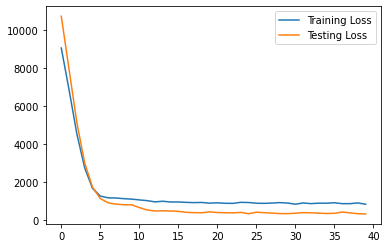

In [573]:
## Plot Training & Validation Loss
plt.plot(history_3.history['loss'], label="Training Loss")
plt.plot(history_3.history['val_loss'], label="Testing Loss")
plt.legend();

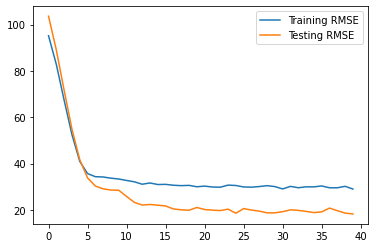

In [574]:
## Plot Training & Validation Accuracy
plt.plot(history_3.history['root_mean_squared_error'], label="Training RMSE")
plt.plot(history_3.history['val_root_mean_squared_error'], label="Testing RMSE")
plt.legend();


#### **Interpretation:**  

The graphs are not as good as the previous ones. 
After epoch 5, the Testing RMSE diverges significantly from the Training RMSE, and so does the loss


In [575]:
model_3.evaluate(test_seq)

5/5 [==============================] - 0s 3ms/step - loss: 335.3101 - root_mean_squared_error: 18.3086 - mae: 14.8686


[335.31005859375, 18.308582305908203, 14.868583679199219]

In [576]:
# baseline
y_test_baseline = [y_train.mean()]*len(y_test)

baseline_RMSE = mean_squared_error(y_test, y_test_baseline)**0.5
baseline_mean = y_train.mean()

print( f"y_test_baseline: {y_test_baseline[0]}, y_train_baseline_mean: {baseline_mean}, baseline_RMSE: {baseline_RMSE} ")


y_test_baseline: 95.47320294640589, y_train_baseline_mean: 95.47320294640589, baseline_RMSE: 23.24519113999734 


#### For the 4th iteration, change the length (number of lags). We could potentially try with a smaller batchsize in the future.  

Do EarlyStopping too

In [577]:
# 16 sequences of len=5 fed through our model at a time
train_seq2 = TimeseriesGenerator( X_train_sc, y_train, length = 5, batch_size=16) 
test_seq2 = TimeseriesGenerator( X_test_sc, y_test, length = 5, batch_size=16) 

In [578]:
# Design RNN - Using LSTM layers & Regularization
model_4 = Sequential()

model_4.add(LSTM(16, input_shape = train_seq2[0][0][0].shape,
              return_sequences=True)) ## First LSTM layer returns hidden state, passes back into self
model_4.add(LSTM(8, return_sequences=False)) ## Second LSTM layer passes outputs forward to next layer

model_4.add(Dense(8, activation = 'relu', kernel_regularizer=l2(0.001)))
model_4.add(Dropout(0.2))
model_4.add(Dense(1))

model_4.compile(
    optimizer="adam",
    loss="mean_squared_error", 
    metrics= [tf.keras.metrics.RootMeanSquaredError(),'mae']
)

model_4.summary()


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 5, 16)             1344      
                                                                 
 lstm_35 (LSTM)              (None, 8)                 800       
                                                                 
 dense_61 (Dense)            (None, 8)                 72        
                                                                 
 dropout_15 (Dropout)        (None, 8)                 0         
                                                                 
 dense_62 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,225
Trainable params: 2,225
Non-trainable params: 0
_________________________________________________________________


In [581]:
EarlyStopping(monitor = "val_root_mean_squared_error", mode = "min", verbose = 1, patience = 20, restore_best_weights=True)


In [582]:
history_4 = model_4.fit(train_seq2, epochs = 40, verbose = 1, validation_data = test_seq2)

Epoch 1/40
246/246 [==============================] - 55s 225ms/step - loss: 864.7153 - root_mean_squared_error: 29.4046 - mae: 23.0446 - val_loss: 245.2056 - val_root_mean_squared_error: 15.6563 - val_mae: 12.3811
Epoch 2/40
246/246 [==============================] - 2s 8ms/step - loss: 872.1381 - root_mean_squared_error: 29.5305 - mae: 23.3113 - val_loss: 294.5007 - val_root_mean_squared_error: 17.1585 - val_mae: 13.8374
Epoch 3/40
246/246 [==============================] - 2s 8ms/step - loss: 857.0294 - root_mean_squared_error: 29.2736 - mae: 23.0948 - val_loss: 304.4745 - val_root_mean_squared_error: 17.4467 - val_mae: 14.0466
Epoch 4/40
246/246 [==============================] - 3s 13ms/step - loss: 872.6570 - root_mean_squared_error: 29.5393 - mae: 23.0634 - val_loss: 286.2821 - val_root_mean_squared_error: 16.9173 - val_mae: 13.7129
Epoch 5/40
246/246 [==============================] - 3s 12ms/step - loss: 854.0726 - root_mean_squared_error: 29.2230 - mae: 22.9584 - val_loss: 29

In [585]:
model_4.evaluate(test_seq2)

5/5 [==============================] - 0s 3ms/step - loss: 288.4825 - root_mean_squared_error: 16.9818 - mae: 13.8853


[288.4825439453125, 16.981815338134766, 13.885337829589844]

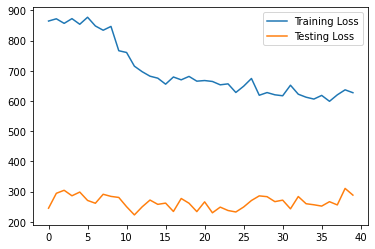

In [586]:
## Plot Training & Validation Loss
plt.plot(history_4.history['loss'], label="Training Loss")
plt.plot(history_4.history['val_loss'], label="Testing Loss")
plt.legend();

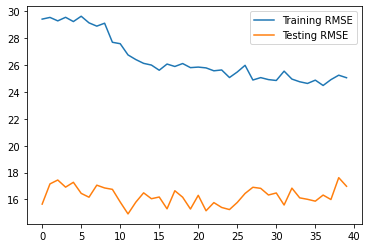

In [587]:
## Plot Training & Validation Accuracy
plt.plot(history_4.history['root_mean_squared_error'], label="Training RMSE")
plt.plot(history_4.history['val_root_mean_squared_error'], label="Testing RMSE")
plt.legend();


#### **Interprettion**: 

Not very good at all. 

#### Final model

In [589]:
model_5 = Sequential()

model_5.add(GRU(128, input_shape = train_seq2[0][0][0].shape, return_sequences=True))
model_5.add(GRU(64, return_sequences=True))
model_5.add(GRU(32, return_sequences=False))

model_5.add(Dense(32, activation = "relu"))
model_5.add(Dropout(0.2))
model_5.add(Dense(16, activation = "relu"))
model_5.add(Dropout(0.2))
model_5.add(Dense(8,  activation = "relu"))
model_5.add(Dense(1))

model_5.compile(
    optimizer="adam",
    loss="mean_squared_error", 
    metrics= [tf.keras.metrics.RootMeanSquaredError(),'mae']
)

model_5.summary()


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_30 (GRU)                (None, 5, 128)            51456     
                                                                 
 gru_31 (GRU)                (None, 5, 64)             37248     
                                                                 
 gru_32 (GRU)                (None, 32)                9408      
                                                                 
 dense_67 (Dense)            (None, 32)                1056      
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_68 (Dense)            (None, 16)                528       
                                                                 
 dropout_19 (Dropout)        (None, 16)              

In [590]:
callbacks = [
    EarlyStopping(monitor = "val_root_mean_squared_error", mode = "min", verbose = 1, patience = 20, restore_best_weights=True),
    ModelCheckpoint("model_checkpoint.keras", save_best_only=True, monitor = "val_root_mean_squared_error", mode = "min")
]

history_5 = model_5.fit(train_seq2, epochs = 100, verbose = 1, validation_data = test_seq2,
                        callbacks = callbacks)

Epoch 1/100
246/246 [==============================] - 11s 18ms/step - loss: 3622.9980 - root_mean_squared_error: 60.1913 - mae: 48.4832 - val_loss: 807.9370 - val_root_mean_squared_error: 28.4242 - val_mae: 23.0958
Epoch 2/100
246/246 [==============================] - 3s 12ms/step - loss: 979.0781 - root_mean_squared_error: 31.2902 - mae: 24.8675 - val_loss: 576.0169 - val_root_mean_squared_error: 24.0004 - val_mae: 18.5400
Epoch 3/100
246/246 [==============================] - 3s 12ms/step - loss: 892.7422 - root_mean_squared_error: 29.8788 - mae: 23.8599 - val_loss: 865.3867 - val_root_mean_squared_error: 29.4175 - val_mae: 24.1372
Epoch 4/100
246/246 [==============================] - 3s 13ms/step - loss: 836.6334 - root_mean_squared_error: 28.9246 - mae: 23.0922 - val_loss: 798.6458 - val_root_mean_squared_error: 28.2603 - val_mae: 22.9337
Epoch 5/100
246/246 [==============================] - 3s 12ms/step - loss: 800.6299 - root_mean_squared_error: 28.2954 - mae: 22.6077 - val_l

#### **Interpretation**: 

Epoch 16 has the best score: 
root_mean_squared_error: 19.9212; val_root_mean_squared_error: 19.4927 

The val_root_mean_squared_error is almost the same as the root_mean_squared_error


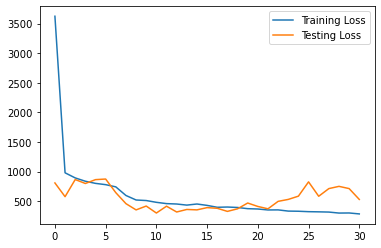

In [593]:
## Plot Training & Validation Loss
plt.plot(history_5.history['loss'], label="Training Loss")
plt.plot(history_5.history['val_loss'], label="Testing Loss")
plt.legend();

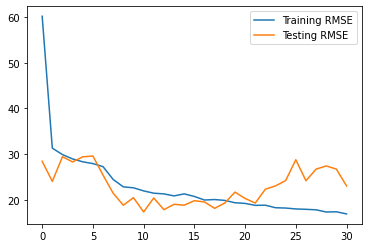

In [594]:
## Plot Training & Validation Accuracy
plt.plot(history_5.history['root_mean_squared_error'], label="Training RMSE")
plt.plot(history_5.history['val_root_mean_squared_error'], label="Testing RMSE")
plt.legend();


In [383]:
train_seq2[0][1] # y_train - batch of 32 - doesn't have first 5 from y_train

array([55, 84, 61, 84, 60, 68, 76, 70, 97, 75, 81, 85, 75, 77, 61, 71])

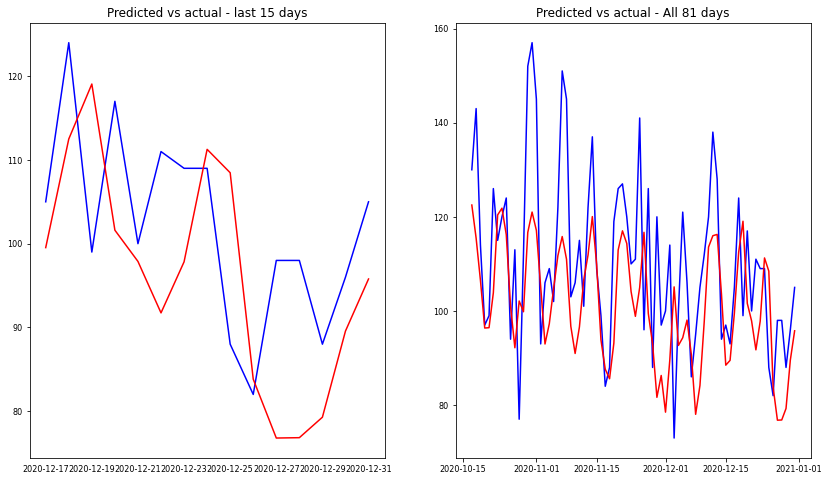

In [596]:
y_train_preds = model_5.predict(train_seq2)
y_test_preds = model_5.predict(test_seq2)

# baseline
y_test_baseline = [y_train.mean()]*len(y_test)

baseline_RMSE = mean_squared_error(y_test, y_test_baseline)**0.5
baseline_mean = y_train.mean()
y_train_baseline = [y_train.mean()]*len(y_train)

#print( metrics.r2_score(y_train, y_train_baseline) ) 
#print( metrics.r2_score(y_test, y_test_baseline) )

#print( f"Training R2 score: {metrics.r2_score( y_train[5:], y_train_preds)}")
#print( f"Test R2 score: {metrics.r2_score( y_test[-15:], y_test_preds[-15:])}") # last few days 

y_test_preds_df = pd.DataFrame(data = y_test_preds, index = y_test[5:].index, columns = ["y_test_preds"])

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,8))

ax1.plot( y_test[-15:], color = 'blue')
ax1.plot( y_test_preds_df[-15:], color = 'red')
ax1.set_title("Predicted vs actual - last 15 days")
ax1.xaxis.set_ticks_position('none')
ax1.tick_params(labelsize=8)

ax2.plot( y_test[5:], color = 'blue')
ax2.plot( y_test_preds_df[:], color = 'red')
ax2.set_title("Predicted vs actual - All 81 days")
ax2.tick_params(labelsize=8)


In [597]:
model_5.evaluate(test_seq2) 


5/5 [==============================] - 0s 5ms/step - loss: 299.9625 - root_mean_squared_error: 17.3194 - mae: 14.1473


[299.9624938964844, 17.319425582885742, 14.147273063659668]

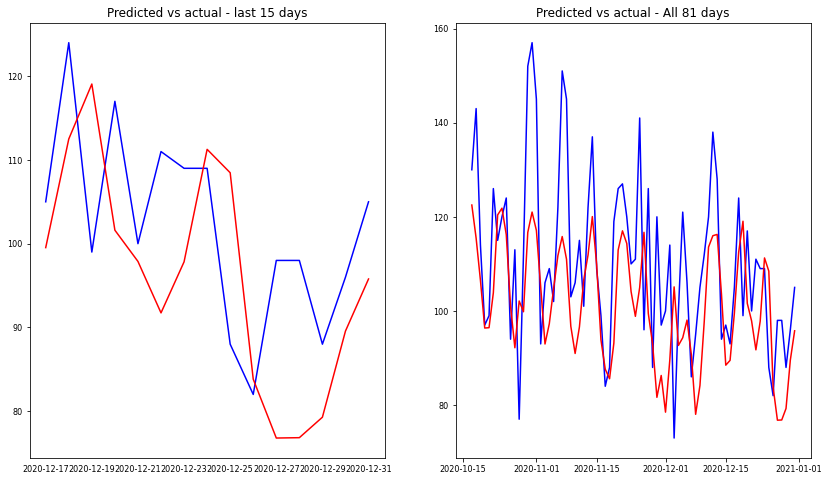

In [601]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,8))

ax1.plot( y_test[-15:], color = 'blue')
ax1.plot( y_test_preds_df[-15:], color = 'red')
ax1.set_title("Predicted vs actual - last 15 days")
ax1.xaxis.set_ticks_position('none')
ax1.tick_params(labelsize=8)

ax2.plot( y_test[5:], color = 'blue')
ax2.plot( y_test_preds_df[:], color = 'red')
ax2.set_title("Predicted vs actual - All 81 days")
ax2.tick_params(labelsize=8)


#### **Interpretation** : 
The predictions are accurate only for a short interval 

### **Summary of RNN modeling:**  

Of the 5 models, the first one performed the best. 

The predictions are quite good, more so in the first few days. Over the total 81 days of predictions, the predictions don't quite match the peaks. In fact, towards the end they overshoot the data considerably.

We used RMSE and MAPE to see how far off are predictions are in absolute numbers (in the same units as our target) and in percent terms. 

The RMSE and MAPE confirm the graphs. The Training RMSE of 14.69 is substantially better than baseline (23.25) and the Test RMSE (15.32) is only marginally higher than the Training RMSE. Our Test MAPE is 10% which indicates that our model’s forecast for fatalities is off by 10% on an average day or 15 fatalities. 



RNN model evaluation 
<img src="./data/RNN_model_evaluation.png"  width="500" height="100">  


### We're done with RNN and the project!! 

The README contains the comparison between the VAR and RNN models. 


## Conclusions<a class="anchor" id="Conclusions"></a>
RNN did a little bit better, though VAR gets to forecast on more than one variable. 





## Next Steps<a class="anchor" id="Next-Steps"></a>

- Need to tune the models to improve performance (time consuming and CPU intensive)
- Room for improvement: 
   - Try Linear Regression with exogenous variables – weather, distracted, construction zone
   - VAR: investigate how to improve weekly and daily forecasts 
   - RNN: Can try weekly and monthly resampling to compare with VAR. Could try further hyper-parameter tuning
 - Clean up warnings: 
        - UserWarning: 


In [604]:
# could try this in the future...

import tensorboard
import datetime
tensorboard.__version__

%load_ext tensorboard
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)  

history = model_3.fit(
    X_train_sc, 
    y_train, 
    validation_data = (X_test_sc, y_test),
    batch_size=64, 
    epochs=50, 
    callbacks=[tb_callback]
)

%tensorboard --logdir logs/fit




The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/50


ValueError: in user code:

    File "/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/sarniraj/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_28" is incompatible with the layer: expected shape=(None, 3, 4), found shape=(None, 4)
